<a href="https://colab.research.google.com/github/mirnanoukari/FoR/blob/main/Assignment3/HA3_FoR_Mirna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trajectory Planning

## Task 3
Position, velocity and acceleration of the robot model:

Every element of a set should contain the information corresponding to the current joint of 6-dof manipulator.

In [3]:
def trajectory_time(q_params, t0): 
  '''
  q_params: [q0, qf, dq, ddq]
  t0: initial time of motion

  Output: 
  t_params: [t0, tau, T, t_f]
  '''

  q0, qf, dq_max, ddq_max = q_params
  delta_q = qf - q0

  t_b1 = delta_q / dq_max
  t_b2 = dq_max / ddq_max
  tau = min(t_b1, t_b2)

  T1 = delta_q / dq_max
  T2 = tau
  T = max(T1, T2)

  t_f = T + tau

  t_params = [t0, tau, T, t_f]

  return t_params



In [4]:
def trapezoidal_trajectory(q_params ,t_params):
  '''
  Output: 
  t: list of timesteps from t0 till tf
  q: list of positions from q0 to qf
  v: list of velocities from beginning to end of motion
  a: list of accelerations from beginning to end of motion
  '''
  
  t0, tau, T, t_f = t_params
  t = np.linspace(t0, t_f, 1024)
  q0, qf, dq_max, ddq_max = q_params
  delta_q = qf - q0
  dq_max1 = delta_q / T
  dq = np.zeros(1024)
  dt = (t_f - t0) / 1024 

  for i in range(1024):
    if t[i] < tau:
      dq[i] = t[i] * dq_max1 / tau

    elif t[i] < T:
      dq[i] = dq_max1 
    else:
      dq[i] = dq_max1 - (t[i] - T) * dq_max1 / tau

  q = np.zeros(1024)
  ddq = np.zeros(1024)
  
  for i in range(1, 1024):
    q[i] = q[i - 1] + dq[i] * dt
  
  for i in range(1023):
    ddq[i] = (dq[i + 1] - dq[i]) / dt

  return t, q, dq, ddq



Synchronization of the 6 joints making them start and end motion at the same time:

In [5]:
def time_synch(t_params_list): 
  '''
  t_params_list: a list of lists of time params of each joint motion [t_params_1, t_params_2, .....t_params_n]

  Output: 
  t_params_sync: list of synchronized time params [t_0, tau, T, t_f]
  '''
  max_t0 = 0
  max_T_tau = 0
  max_tf_t0 = 0
  for t_params in t_params_list:
    t0, tau, T, t_f = t_params
    max_t0 = max(max_t0, t0)
    max_T_tau = max(max_T_tau, T - tau)
    max_tf_t0 = max(max_tf_t0, t_f - t0)

  t0 = max_t0
  tau = t0 + (max_tf_t0 - max_T_tau) / 2
  T = max_T_tau + tau
  t_f = t0 + max_tf_t0
  t_params_sync = [t0, tau, T, t_f]

  return t_params_sync

In [6]:
def trapezoid_p2p(q_params_list, t_params_sync):
  '''
  q_params_list: list of lists of actuator parameters 
  Output: 
  t: list of time steps
  q: list of joint positions after synchronization [[q1], [q2] ...[qn]]
  dq, ddq: list of lists of joint velocities and accelerations in the same format as q
  '''
  q = []
  dq = []
  ddq = []
  for q_params in q_params_list:
    joint_t, joint_q, joint_dq, joint_ddq = trapezoidal_trajectory(q_params, t_params_sync)
    q.append(joint_q)
    dq.append(joint_dq)
    ddq.append(joint_ddq)
    t = joint_t

  return t, q, dq, ddq 

Plotting data for position, velocity and acceleration for each joint:

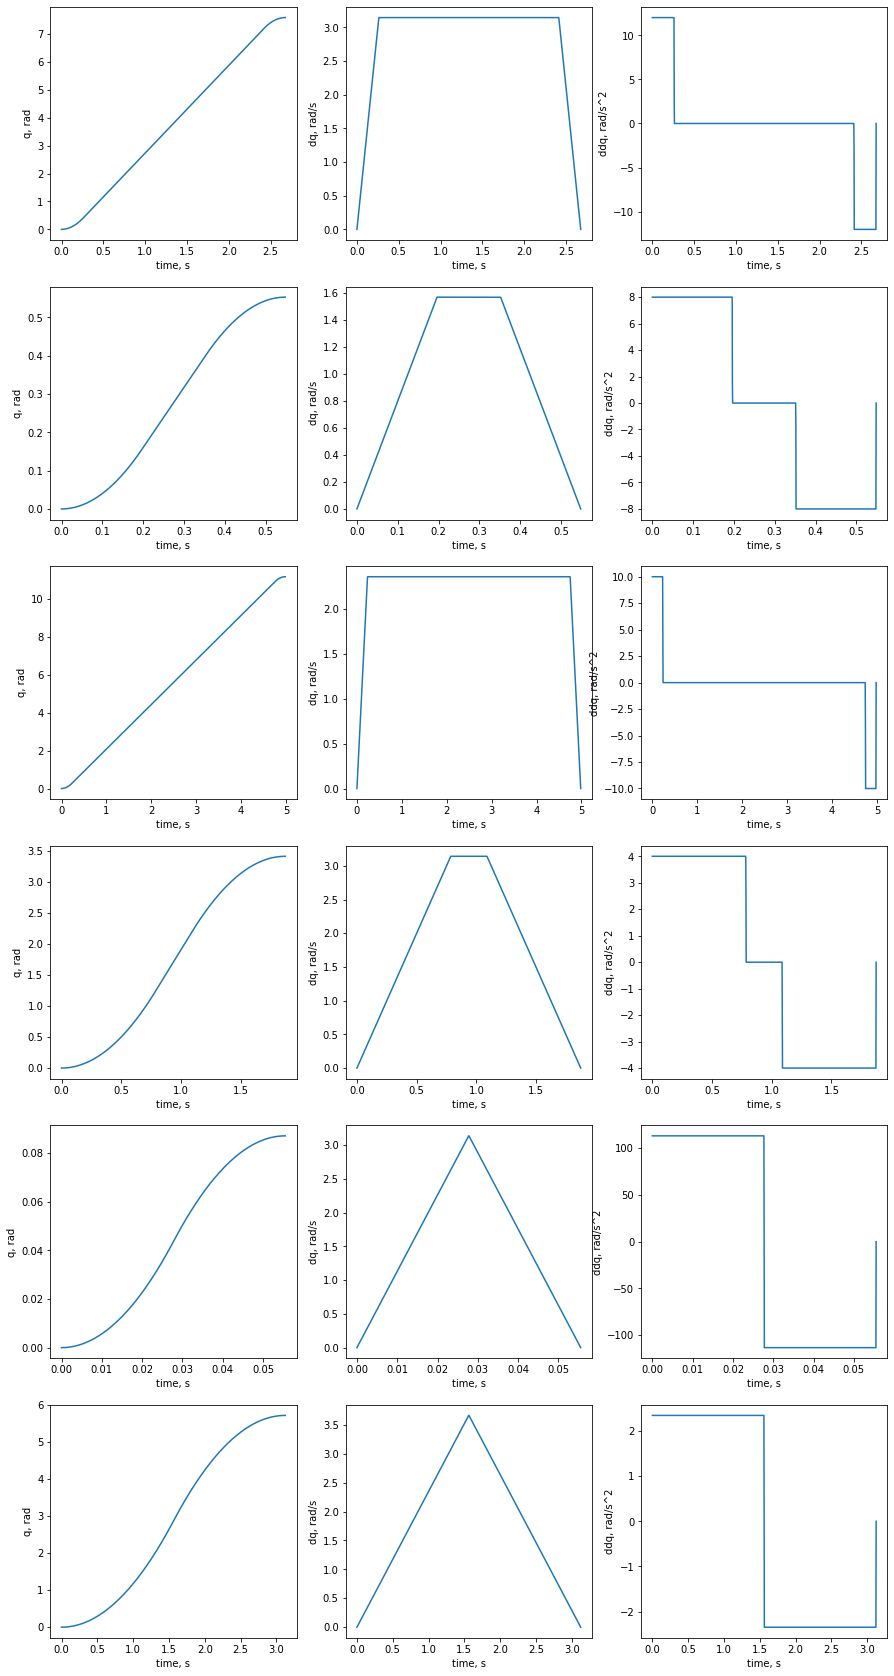

In [7]:
import numpy as np
from numpy import pi, cos, sin
import matplotlib.pyplot as plt


t0 = 0  #initial trajectory time
q0 = np.array([0, 0, 0, 0, 0, 0])
qf = np.array([7.5921,0.5532, 11.1868, 3.4214, 0.0872, 5.7279])
delta_q = qf - q0
dq_max = np.array([3.1459, 1.5708, 2.35619, 3.14159, 3.14159, 3.66519])
ddq_max = np.array([12, 8, 10, 4, 4, 2])

q_params_list = [] #list of q_params

fig, axs = plt.subplots(6, 3)
fig.set_size_inches(15, 30)

for i in range(6):
  q_params = [q0[i], qf[i], dq_max[i], ddq_max[i]]
  t_params = trajectory_time(q_params, t0)
  t, q, dq, ddq = trapezoidal_trajectory(q_params, t_params)

  axs[i, 0].plot(t, q)
  axs[i, 0].set(xlabel='time, s')
  axs[i, 0].set(ylabel='q, rad')
  axs[i, 1].plot(t, dq)
  axs[i, 1].set(xlabel='time, s')
  axs[i, 1].set(ylabel='dq, rad/s')
  axs[i, 2].plot(t, ddq)
  axs[i, 2].set(xlabel='time, s')
  axs[i, 2].set(ylabel='ddq, rad/s^2')
  

Plotting with respect to synchronized motion:

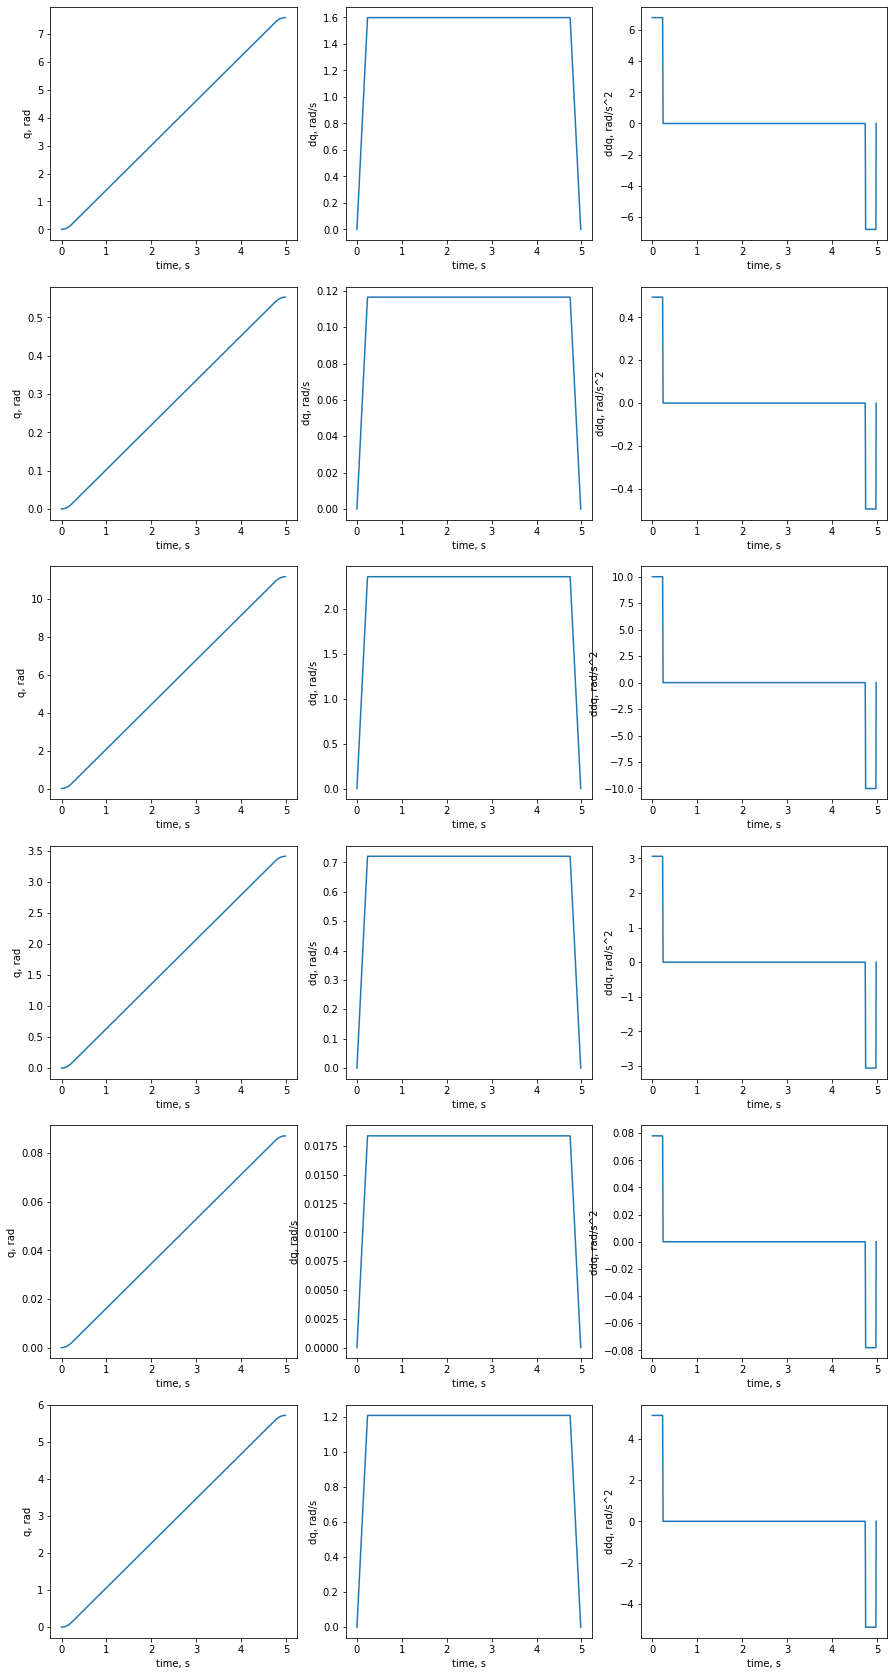

In [8]:
t_params_list = []

for i in range(6):
  q_params = [q0[i], qf[i], dq_max[i], ddq_max[i]]
  t_params = trajectory_time(q_params, t0)
  
  t_params_list.append(t_params)

t_params = time_synch(t_params_list)

fig, axs = plt.subplots(6, 3)
fig.set_size_inches(15, 30)

for i in range(6):
  q_params = [q0[i], qf[i], dq_max[i], ddq_max[i]]
  t, q, dq, ddq = trapezoidal_trajectory(q_params, t_params)

  axs[i, 0].plot(t, q)
  axs[i, 0].set(xlabel='time, s')
  axs[i, 0].set(ylabel='q, rad')
  axs[i, 1].plot(t, dq)
  axs[i, 1].set(xlabel='time, s')
  axs[i, 1].set(ylabel='dq, rad/s')
  axs[i, 2].plot(t, ddq)
  axs[i, 2].set(xlabel='time, s')
  axs[i, 2].set(ylabel='ddq, rad/s^2')

Numerical control assuming f = 220 Hz

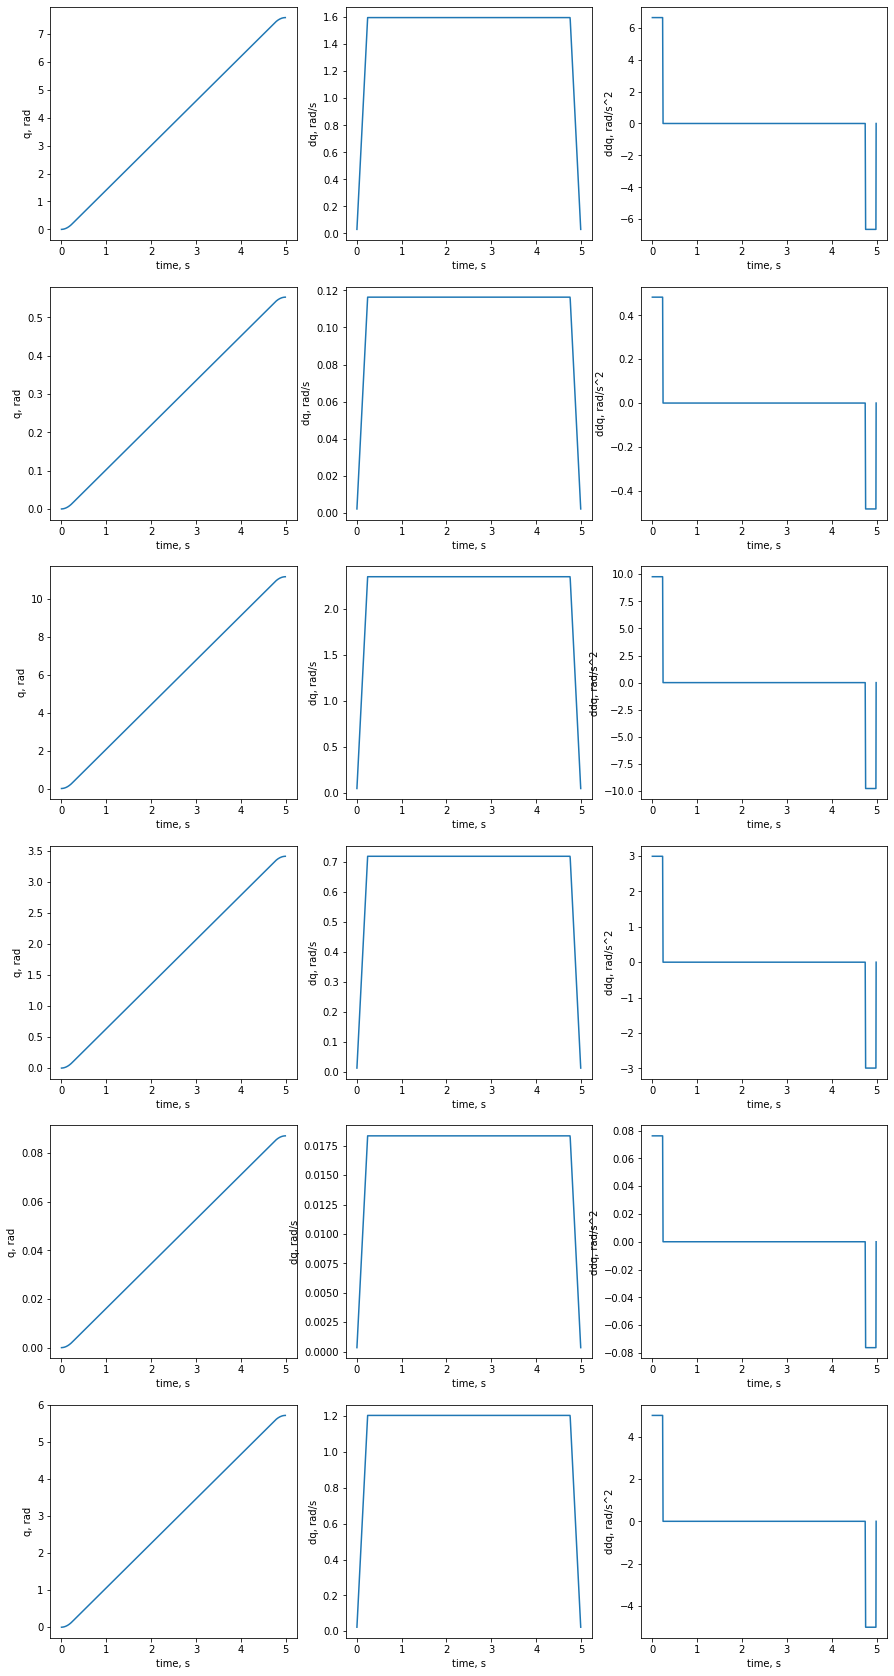

In [9]:
from math import floor

f = 220
dt = 1 / f

t0, tau, T, t_f = t_params

num_t0 = (floor(t0 / dt) + 1) * dt
num_tau = num_t0 + (floor((tau - t0) / dt) + 1) * dt
num_T = num_tau + (floor((T - tau) / dt) + 1) * dt
num_t_f = num_t0 + 2 * (num_tau - num_t0) + (num_T - num_tau)

num_t_params = [num_t0, num_tau, num_T, num_t_f]

num_dq_max = (qf - q0) / num_T
num_ddq_max = num_dq_max / (num_tau - num_t0)

fig, axs = plt.subplots(6, 3)
fig.set_size_inches(15, 30)

for i in range(6):
  q_params = [q0[i], qf[i], dq_max[i], ddq_max[i]]
  t, q, dq, ddq = trapezoidal_trajectory(q_params, num_t_params)

  axs[i, 0].plot(t, q)
  axs[i, 0].set(xlabel='time, s')
  axs[i, 0].set(ylabel='q, rad')
  axs[i, 1].plot(t, dq)
  axs[i, 1].set(xlabel='time, s')
  axs[i, 1].set(ylabel='dq, rad/s')
  axs[i, 2].plot(t, ddq)
  axs[i, 2].set(xlabel='time, s')
  axs[i, 2].set(ylabel='ddq, rad/s^2')

Rewriting Forward Kinematics from the previous assignment to use it for calculating error.

In [10]:
import numpy as np
from numpy.linalg import inv
import sympy as sp

def Rx(q):
   return np.array([[1, 0, 0, 0],
              [0, np.cos(q), - np.sin(q), 0],
              [0, np.sin(q), np.cos(q), 0],
              [0, 0, 0, 1]])
   

def Ry (q):
  return np.array([[np.cos(q), 0, np.sin(q), 0],
              [0, 1, 0, 0],
              [- np.sin(q), 0, np.cos(q), 0],
              [0, 0, 0, 1]])

def Rz(q):
  return np.array([[np.cos(q), - np.sin(q), 0, 0],
              [np.sin(q), np.cos(q), 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

def Tx(d):
   return np.array([[1, 0, 0, d],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
   
def Ty(d):
  return np.array([[1, 0, 0, 0],
              [0, 1, 0, d],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

def Tz(d):
  return np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, d],
              [0, 0, 0, 1]])

l = [1, 1, 1, 1, 1, 1]

def T1(q1):
  return Rz(q1) @ Tz(l[0])

def T2(q2):
  return Rx(q2) @ Tz(l[1])

def T3(q3):
  return Rx(q3) @ Tz(l[2])
  
def T4(q4):
  return Tz(l[3]) @ Rz(q4)

def T5(q5):
  return Ry(q5)

def T6(q6):
  return Rz(q6) @ Tz(l[4]) @ Tz(l[5])

def FK_solve(q, flag):
  A = [T1(q[0]), T2(q[1]), T3(q[2]), T4(q[3]), T5(q[4]), T6(q[5])]
  def f(A):
    ret = np.eye(4)
    for a in A:
      ret = ret @ a
    return ret

  if flag == 'ee': return f(A)
  if flag == 'full': return [f(A[:i+1]) for i in range(6)]

def transform_base(trans, q):
  return trans @ FK_solve(q, 'ee')


Propagated error in end-effector position

In [11]:
final_q1, final_q2 = [], []

for i in range(6):
  q_params = [q0[i], qf[i], dq_max[i], ddq_max[i]]
  num_q_params = [q0[i], qf[i], num_dq_max[i], num_ddq_max[i]]
  t, q1, dq1, ddq1 = trapezoidal_trajectory(num_q_params, num_t_params)
  t, q2, dq2, ddq2 = trapezoidal_trajectory(q_params, t_params)
  final_q1.append(q1[-1])
  final_q2.append(q2[-1])

ee1, ee2 = FK_solve(final_q1, 'ee'), FK_solve(final_q2, 'ee')
print(np.sum(np.abs((ee1 - ee2) ** 2)))

1.1395511248044918e-06
